# IBM HR Analytics : Can we predict employee attrition? 

### This project depicts a fully featured end-to-end Data Science workflow aimed at building models predictive of employee attrition (whether or not an employee leaves a company, in this case: IBM). This project is broken up into a few main parts:

- Data Acquisition 
- Data Cleaning & Pre-Processing
- Exploratory Data Analysis 
- Feature Engineering
- Dataset Preparation (Feature Encoding/Scaling, Train/Test split, etc.)
- Machine Learning Models
- Comparision of Model Results & Best Model Selection 

The tech industry currently has the highest employee turnover rate at 13.2%. Although big tech companies like Google provide great benefits packages and amenities at the office, employees stay at google for an average of 1.1 years. I am hoping that this analysis of employee attrition will help companies look into other variables that may cause employees to leave the company like job involvement, and environment satisfaction. What variables cause employee attrition? 


The dataset used in this analysis is IBM HR Analytics Employee Attrition & Performance. This dataset contains 35 variables that may contribute to employee attrition including, work-life balance, years at the company, age and relationship status. The dataset contains approximately 1470 entries. 

### Imports

In [35]:
# Native
import datetime 
import matplotlib.pyplot as plt 
import os 
import sys

# Non-Native
import numpy as np 
import pandas as pd
import pyspark 
import seaborn as sns
sns.set(style='darkgrid')

#ML Imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

from scipy.stats import ttest_1samp

### Data Acquisition

In [36]:
df = pd.read_csv("attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [37]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### Data Cleaning & Pre-Processing

#### Given the dataframe containing the employee data, clean it up by:
- Converting the target variable (Attrition) into a binary variable (0/1)
- Handing missing / NaN values (in this case, there are none!)


In [38]:
df['Attrition'].replace(to_replace = dict(Yes = 1, No = 0), inplace=True)

In [39]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

### Exploratory Data Analysis 

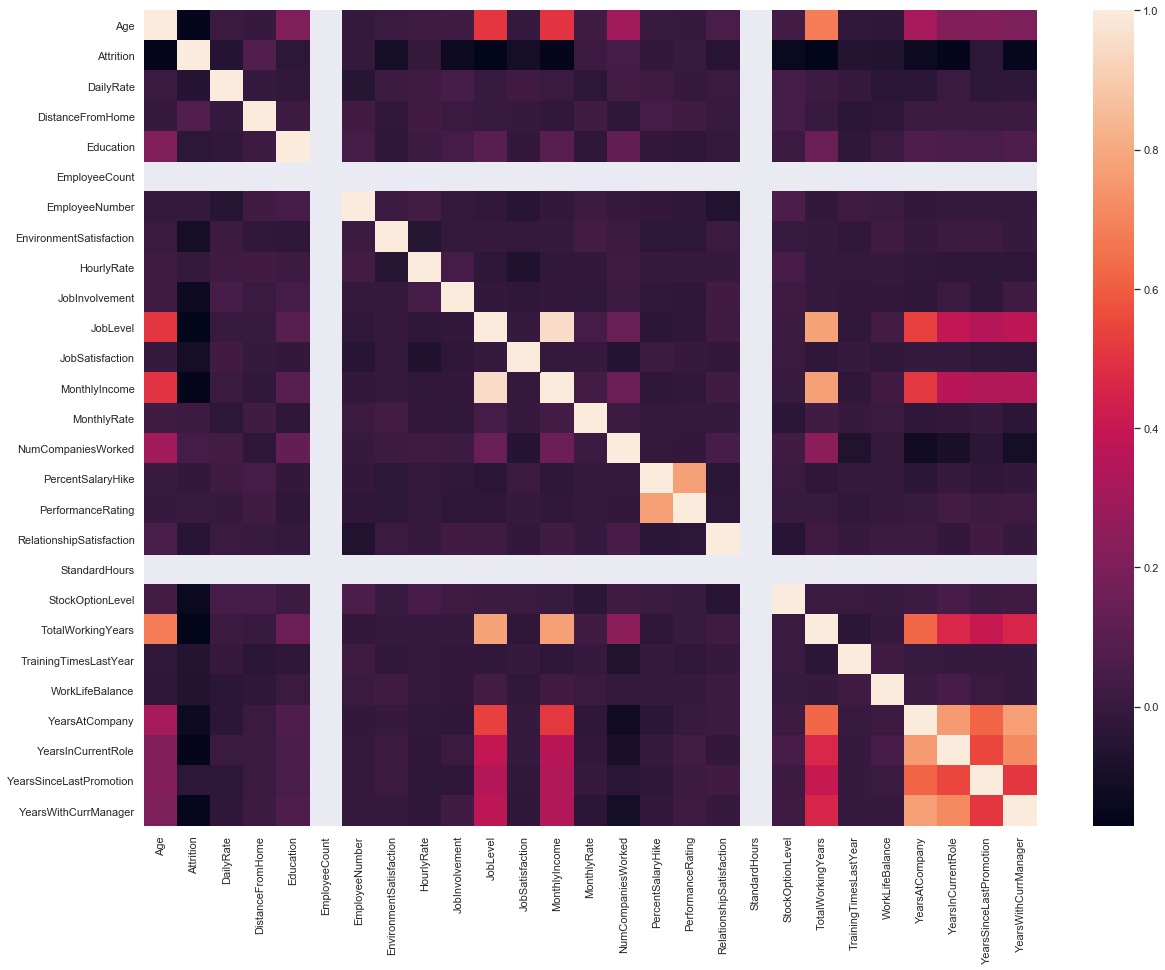

In [40]:
corr = df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

This correlation plot shows that years at the company, years in the current role, years since last promotion and years with the current manager are all correlated with each other. Job level and monthly income are also correlated with these four variables. 

Age is correlated with job level, monthly income, total working years. 

#### Correlation Tests
Tests whether two samples have a linear relationship.

In [41]:
from scipy.stats import pearsonr
stat, p = pearsonr(df['Attrition'], df['Age'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and Age are probably independent')
else:
    print('Attrition and Age are probably dependent')

stat= -0.159, p= 0.000
Attrition and Age are probably dependent


In [42]:
stat, p = pearsonr(df['Attrition'], df['TotalWorkingYears'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and TotalWorkingYears are probably independent')
else:
    print('Attrition and TotalWorkingYears are probably dependent')

stat= -0.171, p= 0.000
Attrition and TotalWorkingYears are probably dependent


In [43]:
stat, p = pearsonr(df['Attrition'], df['JobLevel'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and JobLevel are probably independent')
else:
    print('Attrition and JobLevel are probably dependent')

stat= -0.169, p= 0.000
Attrition and JobLevel are probably dependent


In [44]:
stat, p = pearsonr(df['Attrition'], df['WorkLifeBalance'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and WorkLifeBalance are probably independent')
else:
    print('Attrition and WorkLifeBalance are probably dependent')

stat= -0.064, p= 0.014
Attrition and WorkLifeBalance are probably dependent


#### t-Tests

In [45]:
age = df['Age']
ages_mean = np.mean(age)
print(ages_mean)
tset, pval = ttest_1samp(age, 30)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

36.923809523809524
p-values 4.679915477144685e-147
 we are rejecting null hypothesis


In [46]:
satisfaction = df['JobSatisfaction']
job_satisfaction = np.mean(satisfaction)
print(job_satisfaction)
tset, pval = ttest_1samp(satisfaction, 30)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

2.7285714285714286
p-values 0.0
 we are rejecting null hypothesis


In [47]:
TotalWorkingYears = df['TotalWorkingYears']
working_years = np.mean(TotalWorkingYears)
print(working_years)
tset, pval = ttest_1samp(TotalWorkingYears, 30)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

11.279591836734694
p-values 0.0
 we are rejecting null hypothesis


### Visualizations 

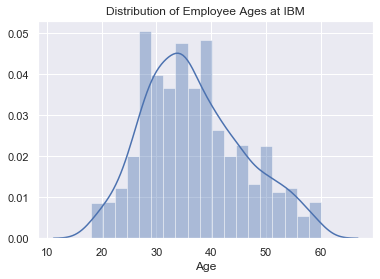

In [48]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Ages at IBM')
sns.distplot(df.Age)

This graph indicates that the average age of Employees at IBM is approximately 35 and is slightly right-skewed indicating that the majority of employees at IBM are young. 

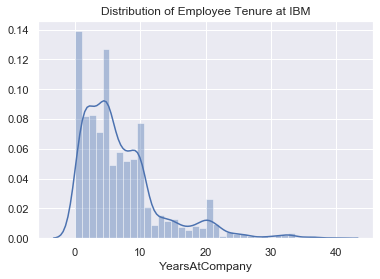

In [49]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Tenure at IBM')
sns.distplot(df.YearsAtCompany)

This graph indicates that the average time spent at IBM is approximately 3 years. 

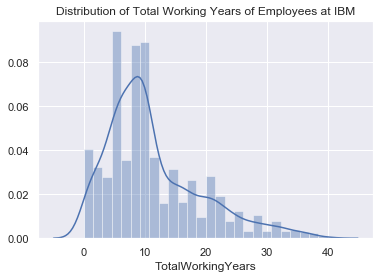

In [50]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Total Working Years of Employees at IBM')
sns.distplot(df.TotalWorkingYears)

This graph indicates that the average working years of employees at IBM is around 10 years. 

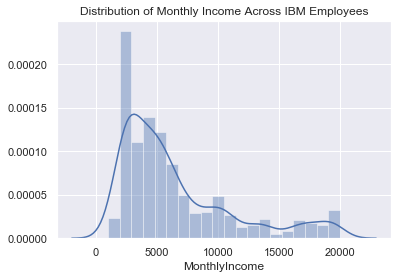

In [51]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Monthly Income Across IBM Employees')
sns.distplot(df.MonthlyIncome)

This graph indicates that the average monthly income is less than 5000 and the graph is right-skewed indicating that the majority of the employees make 5000 or less. 

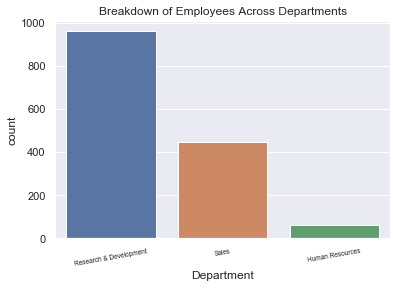

In [52]:
fig, ax = plt.subplots()
ax.set_title('Breakdown of Employees Across Departments')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=6.5, rotation=10)
sns.countplot(df.Department, order=df.Department.value_counts().index)

Around 900 employees work in Research & Development and approximately 400 employees work in Sales with around 70 employees working in Human Resources. 

In [53]:
# Get dataframe where employees left company
attrition_df = df[df['Attrition'] == 1]

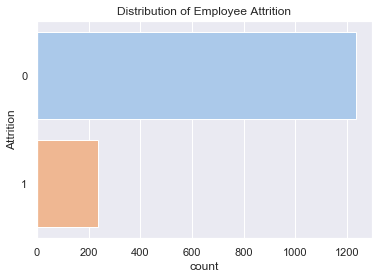

In [54]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Attrition')
sns.countplot(y='Attrition', palette='pastel', data=df)

Around 1200 employees stayed at IBM.

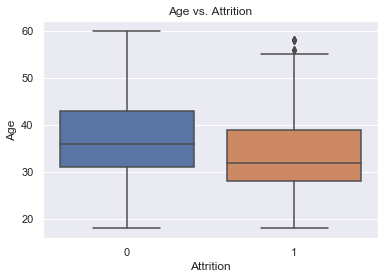

In [55]:
fig, ax = plt.subplots()
ax.set_title('Age vs. Attrition')
sns.boxplot(x='Attrition', y='Age', data=df)

These boxplots show the age distribution of employees that stayed at IBM versus the employees that left. The distribution of employees that left IBM has a mean at approximately  32 years old while the mean of employees that stay is around 36 years old. This shows that younger people are more likely to leave IBM. 

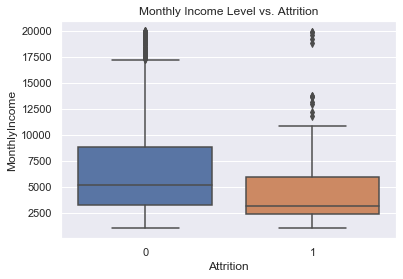

In [56]:
fig, ax = plt.subplots()
ax.set_title('Monthly Income Level vs. Attrition')
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)

These boxplots show the age distribution of employees that stayed at IBM versus the employees that left. The distribution of employees that left IBM has a mean at approximately  32 years old while the mean of employees that stay is around 36 years old. This shows that younger people are more likely to leave IBM. 

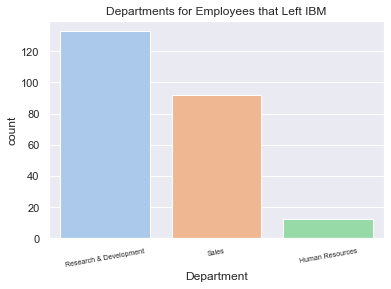

In [57]:
fig, ax = plt.subplots()
  
ax.set_title('Departments for Employees that Left IBM')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=10)

sns.countplot(x='Department', palette='pastel', order=attrition_df.Department.value_counts().index, data=attrition_df)

Most of the people who left IBM were in Research and Development at around 140 people, with 90 people in sales and 15 people in Human Resources.

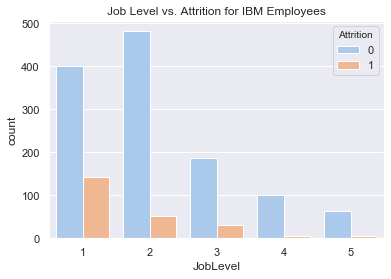

In [58]:
fig, ax = plt.subplots()
ax.set_title('Job Level vs. Attrition for IBM Employees') 
sns.countplot(x='JobLevel', hue='Attrition', palette='pastel', data=df)

This graph shows that entry-level employees are more likely to leave the company than employees at a more senior level. 

In [59]:
def prepare_data(employee_df):
#Make the final preparations to feed our data into our machine learning models. 
# Employee ID Column
    id_employee = ['EmployeeNumber']
# Define our target column, this is our predictor 
    target_column = ['Attrition']
# Handle our categorical variables 
    cols_categorical = employee_df.nunique()[employee_df.nunique() < 15].keys().tolist()
    cols_categorical = [col for col in cols_categorical if col not in target_column]
# Hanlde our numerical columns 
    cols_numerical = [col for col in employee_df.columns if col not in cols_categorical + target_column + id_employee]
# Handle our binary columns 
    cols_binary = employee_df.nunique()[employee_df.nunique() == 2].keys().tolist()
# Handle columns with numerouus values 
    cols_numerous = [col for col in cols_categorical if col not in cols_binary]
# Encode our Binary Columns 
    le = LabelEncoder()
    for col in cols_binary:
        employee_df[col] = le.fit_transform(employee_df[col])
# One-Hot Encoding for Categorical Columns 
    employee_df = pd.get_dummies(data = employee_df, columns = cols_numerous)
    return employee_df 

In [60]:
employee_df = prepare_data(df)

# Define X & Y so we can plug into machine learning models

y = np.array(employee_df.Attrition.tolist())

employee_df.drop(['Attrition'], axis=1, inplace=True)
X = np.array(employee_df.values)

# Feauture Elimation for Features with Low Variance (i.e. if a feature has 0 variance, it's unlikely that there are interesting patterns in the data)
select_crit = VarianceThreshold(threshold=(0.8 * (1-0.8)))
select_crit.fit_transform(X)


# Get the Train / Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)
#print(y_test)

### Baseline models

There are many different machine learning models that can be used to predict employee attrition. We will start by testing a range of models and then focus on improving the high performing models. We will start by testing 10 different models with the original dataset. 

LDA: 0.875058 (0.033246)
KNN: 0.815052 (0.025411)
CART: 0.783032 (0.037393)
NB: 0.751781 (0.046765)
Gboo: 0.858265 (0.024947)
HGB: 0.863839 (0.026924)
XGB: 0.853458 (0.025977)
SVM: 0.839039 (0.031078)
ABoo: 0.863052 (0.034974)
RF: 0.857465 (0.021273)


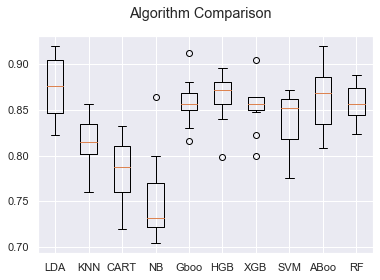

In [61]:
seed = 7
# prepare models
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Gboo', GradientBoostingClassifier()))
models.append(('HGB', HistGradientBoostingClassifier()))
models.append(('XGB',XGBClassifier()))
models.append(('SVM', SVC()))
models.append(('ABoo', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
msgs = []
predict = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    msgs.append(msg)
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Feature Encoding, Scaling, and Final Data Preparations

A few additional variables that might be important when predicting attrition. 

- far_distance is a variable for employees that live more than 10 miles away from work. 
- young_no_love is a variable for employees that are still very young and have no relationship obligations. 
- migrating_worker is a variable for employees that move around companies often.
- comp_adjusted is a variable to compare the adjusted hourly wage with the monthly wage to determine how well-compensated an employee is based on time spent in the office.
- distance_comp is a variable that is a ratio of total monthly income to distance from the work location 


In [62]:
def far_distance(df):
  """ Create a variable for employees with a long distance from the place of work. """
  if df['DistanceFromHome'] > 10:
    return  1
  else:
    return 0 

df['far_distance'] = df.apply(lambda df:far_distance(df), axis=1)

def young_no_love(df):
  """ Create a variable for employees that are young and have no relationship obligations :( """
  
  if df['Age'] < 27 and df['MaritalStatus'] == 'Single':
    return 1
  else:
    return 0 
  
df['young_no_love'] = df.apply(lambda df:young_no_love(df), axis=1)

def migrating_worker(df):
  """Create a variable for employees that move around companies often. """
  
  if df['NumCompaniesWorked'] > 3:
    return 1 
  else:
    return 0 

df['migrating_worker'] = df.apply(lambda df:migrating_worker(df), axis=1)

# Compare the adjusted hourly wage with the monthly wage to determine how well compensated an employee is based on time spent in office
df['comp_adjusted'] = df['HourlyRate'] / df['MonthlyRate']

# Create a variable that is a ratio of total monthly income to distance from the work location 
df['distance_comp'] = df['MonthlyIncome'] / df['DistanceFromHome']

### Machine Learning 

LDA: 0.875058 (0.033246)
KNN: 0.815052 (0.025411)
CART: 0.783845 (0.044891)
NB: 0.751781 (0.046765)
Gboo: 0.858265 (0.026442)
HGB: 0.863839 (0.026924)
XGB: 0.853458 (0.025977)
SVM: 0.839039 (0.031078)
ABoo: 0.863052 (0.034974)
RF: 0.858258 (0.024482)


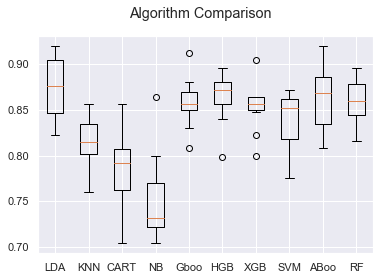

In [93]:
seed = 7
# prepare models
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Gboo', GradientBoostingClassifier()))
models.append(('HGB', HistGradientBoostingClassifier()))
models.append(('XGB',XGBClassifier()))
models.append(('SVM', SVC()))
models.append(('ABoo', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
msgs = []
predict = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    msgs.append(msg)
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the algorithm comparison, it looks like the Linear Discriminant Analysis (0.879 and 0.031583 std), Hist Gradient Boosting Classifier (0.861452 and 0.024033 std), and XGB Classifier(0.861458 and 0.022599 std) should be studied more.

The Hist Gradient Boosting Classifier and the XGB Classifier have less variance so that might mean that they are more confident in their predictions. 

I don't believe the feature engineering helped improve the models. Some models did show very slight improvement(Gboo, HGB, and Random Forest), while CART performed worse. However, I still think that the variables created are important when considering employee attrition. 

### Further analysis on the LDA, Hist Gradient Boost and XGB Classifiers

#### Confusion Matrix for Linear Discriminant Analysis

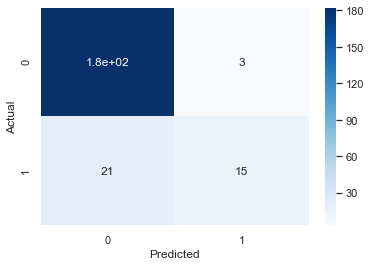

In [105]:
lda = LinearDiscriminantAnalysis()
y_pred = lda.fit(X_train, y_train).predict(X_test)
data = {'y_Actual':   y_test,
        'y_Predicted': y_pred
        }


df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, cmap="Blues")

The confusion matrix for the Linear Discriminant Analysis shows that 15 of the actual ones were predicted correctly while 182 of the actual zeros were predicted correctly. 

#### ROC for Linear Discriminant Analysis

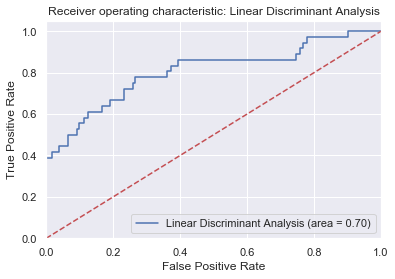

None

In [65]:
lda_roc_auc = roc_auc_score(y_test, lda.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lda.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Linear Discriminant Analysis (area = %0.2f)' % lda_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Linear Discriminant Analysis')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
display(plt.show())

The roc curve for the LDA model shows an area of .70. 

#### Confusion Matrix for Hist Gradient Boosting Classifier

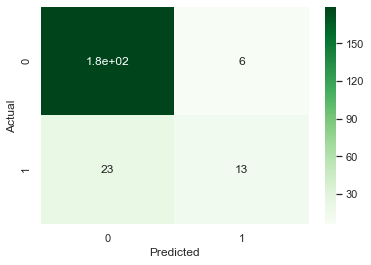

In [67]:
hist = HistGradientBoostingClassifier()
y_pred_hist = hist.fit(X_train, y_train).predict(X_test)

data_hist = {'y_Actual':   y_test,
        'y_Predicted': y_pred_hist
        }


df = pd.DataFrame(data_hist, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, cmap="Greens")

The confusion matrix for the Hist Gradient Boosting Classifier shows that 13 of the ones were predicted correctly and 182 of the zeros were predicted correctly. So far the LDA model did a better job of catching the ones.

#### ROC for Hist Gradient Boosting Classifier

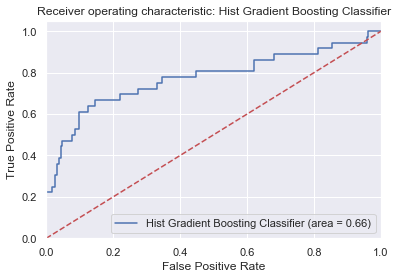

None

In [68]:
hist_roc_auc = roc_auc_score(y_test, hist.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, hist.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Hist Gradient Boosting Classifier (area = %0.2f)' % hist_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Hist Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
display(plt.show())

The roc curve for the Hist Gradient Boosting Classifier shows an area of .66 which is not as good as the LDA model which has an area of .70.

#### Confusion Matrix for XGB Classifier

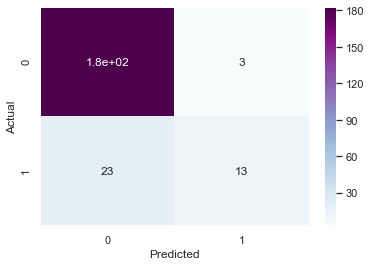

In [91]:
xgb = XGBClassifier()
y_pred_xgb = xgb.fit(X_train, y_train).predict(X_test)

data_xgb = {'y_Actual':   y_test,
        'y_Predicted': y_pred_xgb
        }


df = pd.DataFrame(data_xgb, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, cmap="BuPu")

The confusion matrix for the XGB Classifier shows 13 of the ones were predicted correctly with 182 of the zeros predicted correctly. The XGB Classifier performed similarly to the Hist Boost Classifier but did not perform better than the LDA model.  

#### ROC for XGB Classifier

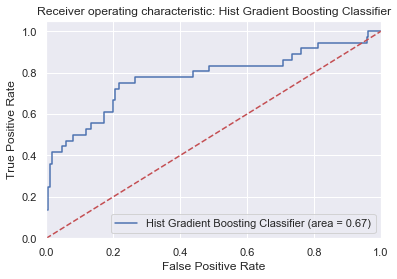

None

In [71]:
xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Hist Gradient Boosting Classifier (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Hist Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
display(plt.show())

The ROC curve for the XGB model shows that the area under the curve is .67. 

According to the ROC curves and confusion matrix of the three classifiers, Linear Discriminant Analysis performed the best. The area covered under the ROC curve was 0.70,  the accuracy score was 0.879 which means that 87% of the time we can accurately predict attrition based on the given variables in the dataset.

This means that we can use the LDA model to try and accurately predict attrition. Next, we will try and optimize the LDA model in order to better predict attrition. 

#### Parameter Tuning on LDA

In [98]:
from sklearn.model_selection import GridSearchCV

clf = LinearDiscriminantAnalysis()
grid_values = {'solver':['lsqr','eigen'],'shrinkage':[0.00001,0.5,0.7,0.08,0.1,0.02,0.34,0.9]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring='f1')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_grid = grid_clf_acc.predict(X_test)


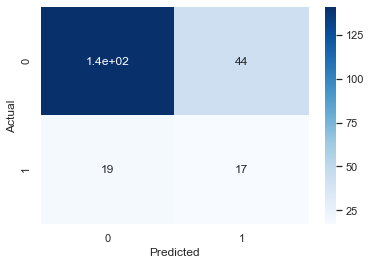

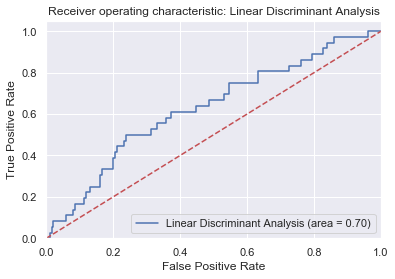

None

In [99]:
data_lda = {'y_Actual':   y_test,
        'y_Predicted': y_pred_grid
        }


df = pd.DataFrame(data_lda, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, cmap="Blues")



fpr, tpr, thresholds = roc_curve(y_test, grid_clf_acc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Linear Discriminant Analysis (area = %0.2f)' % lda_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Linear Discriminant Analysis')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
display(plt.show())

#### Model Selection

The roc curve shows that the model with the grid search actually performed the same as the LDA model without any parameter tuning. The LDA model with parameter tuning did a better job of capturing the 1s. 

This model is better for our business case since the number of ones captures the number of people that actually left IBM. We want to make sure we can capture the most amount of 1s in order to accurately predict attrition. This means that the variables in the data set are useful to look at when determining if an employee will leave IBM, some of these variables are Age, Job Level, Monthly Income, and Total Working Years.